<a href="https://colab.research.google.com/github/josuelopes512/naive-bayes/blob/master/naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from random import choice

In [2]:
class Bayes_Classifier:
    def __init__(self) -> None:
      pass
    
    def __init__(self, *args, **kwargs):
      self.carrega_tabela("naive_bayes_classificador.csv")
      self.outlook = self.probability_select_class(kwargs.get('outlook', args[0]), 'Target', kwargs.get("play_golf", args[4]))[1]
      self.temp = self.probability_select_class(kwargs.get('temp', args[1]), 'Target', kwargs.get("play_golf", args[4]))[1]
      self.humidity = self.probability_select_class(kwargs.get('humidity', args[2]), 'Target', kwargs.get("play_golf", args[4]))[1]
      self.windy = self.probability_select_class(kwargs.get('windy', args[3]), 'Target', kwargs.get("play_golf", args[4]))[1]
      self.play_golf = self.calculate_prior('Target')[0][kwargs.get("play_golf", args[4])]

    def carrega_tabela(self, tabela):
      self.csv = pd.read_csv(tabela, sep=',')

    def view_table(self):
      return self.csv
    
    def probability_select_class(self, label, prob_target, value_target):
      tabela = self.csv
      prob_nome_coluna = None
      for i in list(tabela.columns):
        if label in sorted(list(tabela[i].unique())):
          prob_nome_coluna = i
      tabelax = tabela[tabela[prob_nome_coluna]==label]
      k = tabelax[prob_target]
      x = tabela[tabela[prob_target]==value_target]
      calc = len(tabelax[k==value_target])/len(x) if len(tabelax[k==value_target]) != 0 else (len(tabelax[k==value_target]) + 1)/(len(x) + 3)
      return (tabelax, calc, len(tabelax[k==value_target]), len(x))

    def calculate_prior(self, Y):
      tabela = self.csv
      classes = sorted(list(tabela[Y].unique()))
      new_dic = dict()
      for i in classes:
        new_dic.update({
            i: len(tabela[tabela[Y]==i])/len(tabela)
      })
      return new_dic, tabela
    
    def result_probability(self):
      return (self.outlook*self.temp*self.humidity*self.windy*self.play_golf)


In [3]:
class Calc_prob:
    def __init__(self, genero, idade, escolaridade, profissao):
        self.bayes_classify_yes = Bayes_Classifier(genero, idade, escolaridade, profissao, 1)
        self.bayes_classify_no = Bayes_Classifier(genero, idade, escolaridade, profissao, 0)
        self.result_prob_yes = self.bayes_classify_yes.result_probability()
        self.result_prob_no = self.bayes_classify_no.result_probability()
        self.table = self.bayes_classify_no.view_table()
        self.final_probabilty = {
            "YES": self.calc_prob(self.result_prob_yes, self.result_prob_no), 
            "NO" : self.calc_prob(self.result_prob_no, self.result_prob_yes)
        }
        self.lists = self.sorted_list()

    def calc_prob(self, a, b):
        return a/(a+b)

    def sorted_list(self):
        k = dict()
        for i in list(self.table.columns):
            k.update({i: []})
            for j in sorted(list(self.table[i].unique())):
                k[i].append(j)
        return k
    
    def rand_values_reals(self):
        x = {0: [], 1: [], 'targets': []}
        count = 0
        while count < 200:
            a = self.table.loc[choice([i for i in range(len(self.table.index))])]
            xk = []
            for i in list(self.table.columns):
                xk.append(a[i])
            b = Bayes_Classifier(*xk).result_probability()
            x[xk[-1]].append(b)
            x['targets'].append(xk[-1])
            count +=1
        return x

    def rand_probability_predict(self):
        x = {0: [], 1: [], 'targets': []}
        cont = 0
        while cont < 200:
            genero = choice(self.lists['Genero'])
            idade = choice(self.lists['Idade'])
            escolaridade = choice(self.lists['Escolaridade'])
            profissao = choice(self.lists['Profissao'])
            target = choice(self.lists['Target'])
            k = Bayes_Classifier(genero, idade, escolaridade, profissao, target).result_probability()
            x[target].append(k)
            x['targets'].append(target)
            cont += 1
        return x

    def get_confusion_matrix(self):
        reais = self.rand_values_reals()['targets']
        preditos = self.rand_probability_predict()['targets']
        labels = list(self.table['Target'].unique())

        # não implementado
        if len(labels) > 2:
            return None

        if len(reais) != len(preditos):
            return None
        
        # considerando a primeira classe como a positiva, e a segunda a negativa
        true_class = labels[0]
        negative_class = labels[1]

        # valores preditos corretamente
        tp = 0
        tn = 0
        
        # valores preditos incorretamente
        fp = 0
        fn = 0
        
        for (indice, v_real) in enumerate(reais):
            v_predito = preditos[indice]

            # se trata de um valor real da classe positiva
            if v_real == true_class:
                tp += 1 if v_predito == v_real else 0
                fp += 1 if v_predito != v_real else 0
            else:
                tn += 1 if v_predito == v_real else 0
                fn += 1 if v_predito != v_real else 0
        
        return np.array([
            # valores da classe positiva
            [ tp, fp ],
            # valores da classe negativa
            [ fn, tn ]
        ])

    def acuracia(self, matriz):
        predicoes_corretas = matriz[0][0] + matriz[1][1]
        totas_as_predicoes = matriz[0][0] + matriz[0][1] + matriz[1][0] + matriz[1][1]
        return predicoes_corretas/totas_as_predicoes

    def recall(self, matriz):
        tp = matriz[0][0]
        tp_fn = matriz[0][0] + matriz[1][0]
        return tp/tp_fn
    
    def precisao(self, matriz):
        tp = matriz[0][0]
        tp_fp = matriz[0][0] + matriz[0][1]
        tn  = matriz[1][1]
        tn_fn = matriz[1][1] + matriz[1][0]
        return {'True': tp/tp_fp, 'Negative': tn/tn_fn}
    
    def f1_score(self, matriz):
        precisao = self.precisao(matriz)['True']
        recall = self.recall(matriz)

        return 2*((precisao*recall)/(precisao+recall))


In [4]:
k = Calc_prob("F","a - Ate 25 anos","Fundamental","b")
x = k.get_confusion_matrix()
print('Matriz de Confusão: \n{}'.format(x))
print('Acuracia: {}'.format(k.acuracia(x)))
print('Precisão: {}'.format(k.precisao(x)))
print('f1_score: {}'.format(k.f1_score(x)))
print('recall: {}'.format(k.recall(x)))

Matriz de Confusão: [[19 28]
 [67 86]]
Acuracia 0.525
Precisão {'True': 0.40425531914893614, 'Negative': 0.5620915032679739}
f1_score 0.2857142857142857
recall 0.22093023255813954


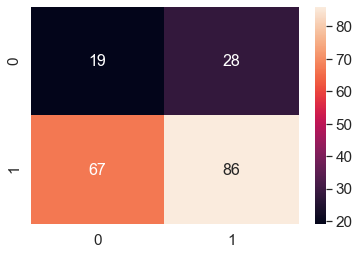

In [5]:
df = pd.DataFrame(x, range(2), range(2))
sn.set(font_scale=1.4)
sn.heatmap(df, annot=True,annot_kws={"size": 16})

Index(['Genero', 'Idade', 'Escolaridade', 'Profissao', 'Target'], dtype='object')
AxesSubplot(0.125,0.125;0.775x0.755)


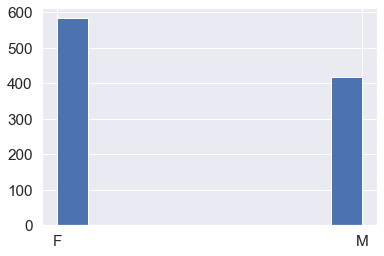

In [6]:
print(k.table.columns)
print(k.table['Genero'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


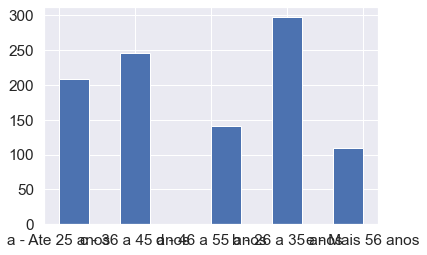

In [7]:
print(k.table['Idade'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


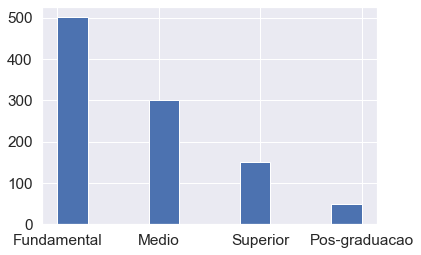

In [8]:
print(k.table['Escolaridade'].hist())

AxesSubplot(0.125,0.125;0.775x0.755)


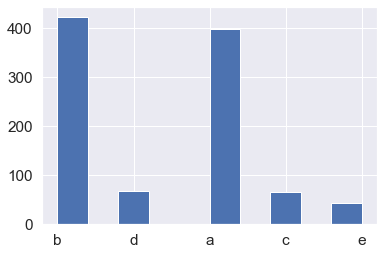

In [9]:
print(k.table['Profissao'].hist())